In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle

from useful import *

## I. Camera Calibration

### I.1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [30]:
# Prepare object points
nx = 9 # Number of inside corners in any given row
ny = 6 # Number of inside corners in any given column

# Read in and make a list of calibration images

# glob allows us to read in files with consistent file names
# e.g. calibration-1.jpg, calibration-2.jpg...
images = glob.glob("camera_cal/calibration*.jpg")

# Initialise image and object point arrays
objpoints = []
imgpoints = []

# Generate object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

def cal_undistort(img, objpoints, imgpoints):
    """Returns undistorted image."""
    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

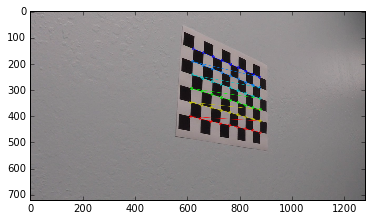

In [31]:
for fname in images:

    # Read in image
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    # Parameters: (image, chessboard dims, param for any flags)
    # chessboard dims = inside corners, not squares.
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Fill image point and object point arrays
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

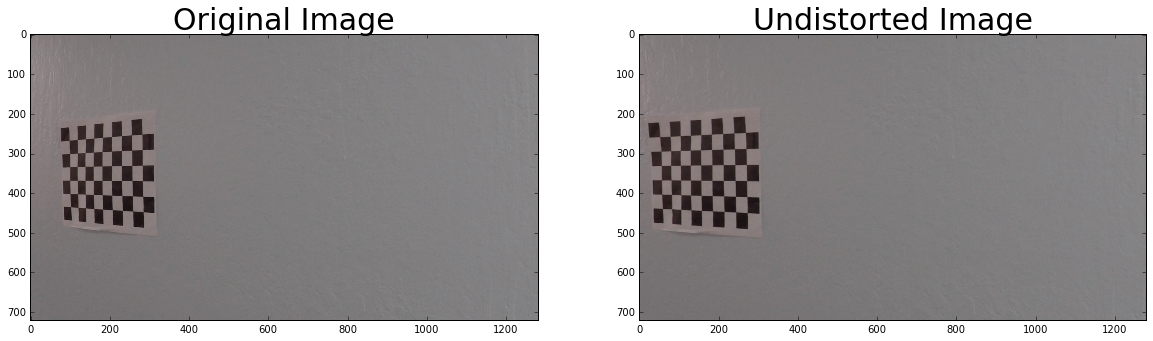

In [32]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration11.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_calibration_result.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [33]:
with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

## II. Image Pipeline

## IIA. Initial runthrough of image pipeline

### II.2. Apply the distortion correction to the raw image.

In [34]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

from useful import *

with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

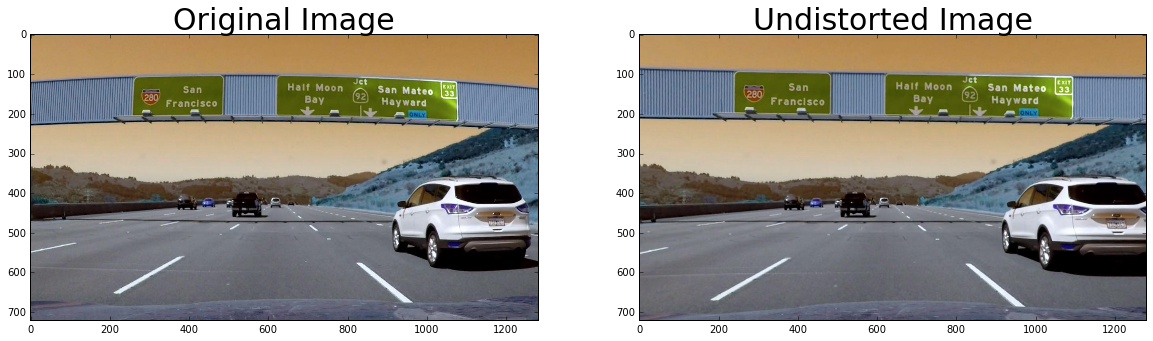

In [35]:
raw = cv2.imread("test_images/quiz.png")

image = cv2.undistort(raw, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(raw)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=30)

In [36]:
# Parameters
imshape = raw.shape

height = raw.shape[0]
offset = 50
offset_height = height - offset
half_frame = raw.shape[1] // 2
steps = 6
pixels_per_step = offset_height / steps
window_radius = 200
medianfilt_kernel_size = 51
horizontal_offset = 40

blank_canvas = np.zeros((720, 1280))
colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

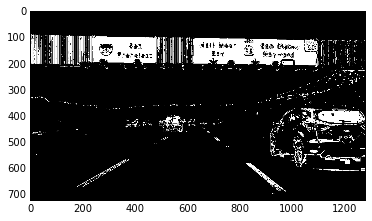

In [37]:
xgrad_thresh_temp = (40,100)
s_thresh_temp=(150,255)

combined_binary = apply_threshold_v2(image, xgrad_thresh=xgrad_thresh_temp, s_thresh=s_thresh_temp)
plt.imshow(combined_binary, cmap="gray")

### 4. Apply a perspective transform to rectify binary image ("birds-eye view").

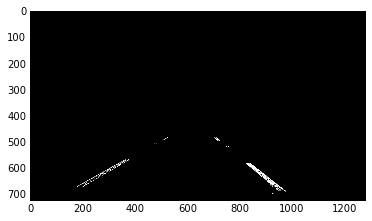

In [38]:
vertices = np.array([[(0,imshape[0]),(550, 470), (700, 470), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = region_of_interest(combined_binary, vertices)
plt.imshow(masked_image, cmap="gray")

In [39]:
src = np.float32(
    [[120, 720],
     [550, 470],
     [700, 470],
     [1160, 720]])

dst = np.float32(
    [[200,720],
     [200,0],
     [1080,0],
     [1080,720]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

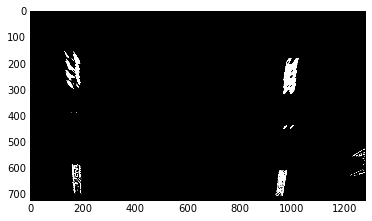

In [40]:
# Warp onto birds-eye-view
# Previous region-of-interest mask's function is absorbed by the warp
warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap="gray")

### 5. Detect lane pixels and fit to find lane boundary.

In [41]:
from scipy import signal

Left coeffs: [  5.88743515e-06   2.31173028e-02   1.59207944e+02]
righty[0]: , 708.0 , rightx[0]:  905
Right coeffs:  [  5.21543266e-05  -1.33379537e-01   1.02130468e+03]


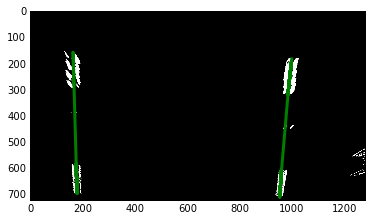

In [42]:
# Histogram and get pixels in window

leftx, lefty, rightx, righty = histogram_pixels(warped, horizontal_offset=horizontal_offset)

# Fit a second order polynomial to each fake lane line
left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
print("Left coeffs:", left_coeffs)
print("righty[0]: ,", righty[0], ", rightx[0]: ", rightx[0])
right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)
print("Right coeffs: ", right_coeffs)

# Plot data

plt.plot(left_fit, lefty, color='green', linewidth=3)
plt.plot(right_fit, righty, color='green', linewidth=3)
plt.imshow(warped, cmap="gray")

Left coeffs:  [  5.88743515e-06   2.31173028e-02   1.59207944e+02]
Right fit:  [  5.21543266e-05  -1.33379537e-01   1.02130468e+03]


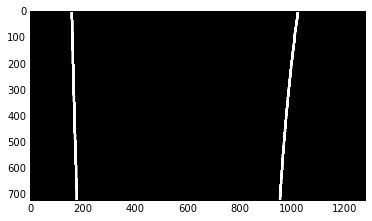

In [43]:
print("Left coeffs: ", left_coeffs)
print("Right fit: ", right_coeffs)
polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
plt.imshow(polyfit_drawn, cmap="gray")

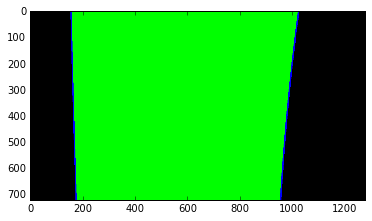

In [44]:
trace = colour_canvas
trace[polyfit_drawn > 1] = [0,0,255]
area = highlight_lane_line_area(blank_canvas, left_coeffs, right_coeffs)
trace[area == 1] = [0,255,0]
plt.imshow(trace)

Section IIA.5 reference: 
* https://github.com/pkern90/CarND-advancedLaneLines

### 6. Determine curvature of the lane and vehicle position with respect to center.

In [45]:
# Determine curvature of the lane
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = 500
left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                /(2 * left_coeffs[0]))
right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                 /(2 * right_coeffs[0]))
print("Left lane curve radius: ", left_curverad, "pixels")
print("Right lane curve radius: ", right_curverad, "pixels")
curvature = (left_curverad + right_curverad) / 2
centre = center(719, left_coeffs, right_coeffs)
min_curvature = min(left_curverad, right_curverad)

Left lane curve radius:  85033.8179839 pixels
Right lane curve radius:  9681.96382646 pixels


[Radius of Curvature formula from Wikipedia](https://en.wikipedia.org/wiki/Radius_of_curvature)


### 7. Warp the detected lane boundaries back onto the original image.

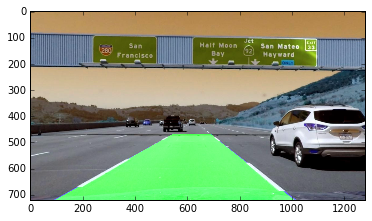

In [46]:
# Warp lane boundaries back onto original image
lane_lines = cv2.warpPerspective(trace, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

# Convert to colour
combined_img = cv2.add(lane_lines, image)
plt.imshow(combined_img)

Note that the xs are a function of the ys, not the other way round.

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


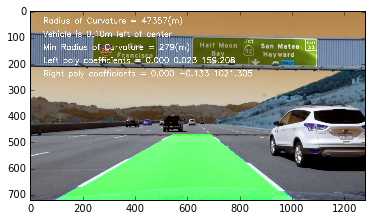

In [47]:
add_figures_to_image(combined_img, curvature=curvature, 
                     vehicle_position=centre, 
                     min_curvature=min_curvature,
                     left_coeffs=left_coeffs,
                     right_coeffs=right_coeffs)
plt.imshow(combined_img)

References I looked at while troubleshooting:
* https://github.com/mohankarthik/CarND-AdvancedLaneLines-P4
* https://github.com/pkern90/CarND-advancedLaneLines

## IIB.  Image pipeline

In [48]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
#whether display the detail image
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
np.save('mtx.npy',mtx)
np.save('dist.npy',dist)

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

np.set_printoptions(threshold=np.inf)  
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients for the recent n number fits
        self.recent_fit = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = []  
        #current fit
        self.fit=[]
        #radius of curvature of the line
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values of the last fits of the line
        self.fitx=None
        #y values of the last fits of the line
        self.fity=None
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
nLineNum = 1 #the number of average x values of the fitted line
imgnum=0
dispdetail=False
# Set the width of the windows +/- margin
margin = 50
# Set minimum number of pixels found to recenter window
minpix = 50

def dispLineMess(myline):
        print('----------------------')
        print (len(myline.recent_xfitted))
        print (myline.bestx)
        print (len(myline.recent_fit))
        print (myline.best_fit)
        print (myline.radius_of_curvature)
        print (myline.line_base_pos)
        print (myline.diffs)
        print (len(myline.allx))
        print (len(myline.ally))
        print (myline.radius_of_curvature)
        print (myline.line_base_pos)
        print('----------------------')
    
def calibrate(img):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    objpoints=[]
    imgpoints=[]
    objp=np.zeros((ny*nx,3),np.float32)
    objp[:,:2]=np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    objpoints.append(objp)
    imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    #dst = cv2.undistort(img, mtx, dist, None, mtx)
    if (ret):
        return mtx,dist
def corners_unwarp(img, nx, ny, mtx, dist):

    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        #cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        offset = 100 # offset for dst points
        img_size = (gray.shape[1], gray.shape[0])
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M
def DispImg(img,undistortedimg):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undistortedimg)
    ax2.set_title('Undistorted and Warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.imshow(undistortedimg)
    plt.show()
def ColorAndGradientThresholds(img,mtx, dist,thresh_min,thresh_max,s_thresh_min,s_thresh_max,disp):
    #first,undistort image
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    # Plotting thresholded images
    if (disp):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Stacked thresholds')
        ax1.imshow(color_binary)

        ax2.set_title('Combined S channel and gradient thresholds')
        ax2.imshow(combined_binary, cmap='gray')
        plt.show()
    return combined_binary
def findLineFromSlidingWindow(binary_warped,disp):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0]-1 - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        #(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        #(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 


    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ###############################
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx,right_fitx,ploty,left_fit,right_fit,leftx,lefty,rightx,righty,nonzerox,nonzeroy,left_lane_inds,right_lane_inds
def findLineFromFit(binary_warped,disp,left_fit,right_fit):    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx,right_fitx,ploty,left_fit,right_fit,leftx,lefty,rightx,righty,nonzerox,nonzeroy,left_lane_inds,right_lane_inds
def findlines(binary_warped,disp):
    binary_warped[:,:200]=0
    binary_warped[:,1200:]=0
    # Assuming you have created a warped binary image called "binary_warped"
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    #mylineL.detected=False
    if (mylineL.detected==False):
        left_fitx,right_fitx,ploty,left_fit,right_fit,leftx,lefty,rightx,righty,nonzerox,nonzeroy,left_lane_inds,right_lane_inds=findLineFromSlidingWindow(binary_warped,disp)
        line_base_posL = (left_fit[0]*719**2 + left_fit[1]*719 + left_fit[2])*xm_per_pix
        line_base_posR = (right_fit[0]*719**2 + right_fit[1]*719 + right_fit[2])*xm_per_pix
    else:
        left_fitx,right_fitx,ploty,left_fit,right_fit,leftx,lefty,rightx,righty,nonzerox,nonzeroy,left_lane_inds,right_lane_inds=findLineFromFit(binary_warped,disp,mylineL.fit,mylineR.fit)
        line_base_posL = (left_fit[0]*719**2 + left_fit[1]*719 + left_fit[2])*xm_per_pix
        line_base_posR = (right_fit[0]*719**2 + right_fit[1]*719 + right_fit[2])*xm_per_pix
    #save line_base_pos
    mylineL.line_base_pos = line_base_posL
    mylineR.line_base_pos = line_base_posR
    #save current fitx
    mylineL.fitx=left_fitx
    mylineL.fity=ploty
    mylineR.fitx=right_fitx
    mylineR.fity=ploty
    #save current x
    mylineL.allx=leftx
    mylineL.ally=lefty
    mylineR.allx=rightx
    mylineR.ally=righty
    #save the recent n number fitx
    leny=len(ploty)
    lenrecentx=len(mylineL.recent_xfitted)
    if (lenrecentx>=(nLineNum*leny)):
        mylineL.recent_xfitted=mylineL.recent_xfitted[lenrecentx-(nLineNum-1)*leny:]
        mylineL.recent_xfitted.append(list(left_fitx))
        mylineR.recent_xfitted=mylineR.recent_xfitted[lenrecentx-(nLineNum-1)*leny:]
        mylineR.recent_xfitted.append(list(right_fitx))
    else:
        mylineL.recent_xfitted.append(list(left_fitx))
        mylineR.recent_xfitted.append(list(right_fitx))
    #detected=true
    mylineL.detected=True
    mylineR.detected=True
    #save the recent n number coefficients
    lenrecentfit=len(mylineL.recent_fit)
    if (lenrecentfit>=nLineNum):
        mylineL.recent_fit=mylineL.recent_fit[lenrecentfit-(nLineNum-1):]
        mylineL.recent_fit.append([left_fit[0],left_fit[1],left_fit[2]])
        mylineR.recent_fit=mylineR.recent_fit[lenrecentfit-(nLineNum-1):]
        mylineR.recent_fit.append([right_fit[0],right_fit[1],right_fit[2]])
    else:
        mylineL.recent_fit.append([left_fit[0],left_fit[1],left_fit[2]])
        mylineR.recent_fit.append([right_fit[0],right_fit[1],right_fit[2]])
    #calculate the average of n number coefficients
    lenfit=len(mylineL.recent_fit)
    l0=sum(np.array(mylineL.recent_fit))[0]/lenfit
    l1=sum(np.array(mylineL.recent_fit))[1]/lenfit
    l2=sum(np.array(mylineL.recent_fit))[2]/lenfit
    mylineL.best_fit=[l0,l1,l2]
    l0=sum(np.array(mylineR.recent_fit))[0]/lenfit
    l1=sum(np.array(mylineR.recent_fit))[1]/lenfit
    l2=sum(np.array(mylineR.recent_fit))[2]/lenfit
    mylineR.best_fit=[l0,l1,l2]
    #calculate the difference in fit coefficients between last and new fits
    mylineL.diffs=[left_fit[0]-mylineL.recent_fit[-1][0],left_fit[1]-mylineL.recent_fit[-1][1],left_fit[2]-mylineL.recent_fit[-1][2]]
    mylineR.diffs=[right_fit[0]-mylineR.recent_fit[-1][0],right_fit[1]-mylineR.recent_fit[-1][1],right_fit[2]-mylineR.recent_fit[-1][2]]
    mylineL.fit=left_fit
    mylineR.fit=right_fit
    # Define conversions in x and y from pixels space to meters
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    mylineL.radius_of_curvature=left_curverad
    mylineR.radius_of_curvature=right_curverad

    if (disp):
        plt.figure(figsize=(80,40))
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    return out_img,ploty
def drawlines(undist,Minv,disp):
    # Create an image to draw the lines on
    warped=cv2.cvtColor(undist,cv2.COLOR_RGB2GRAY)
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([mylineL.fitx, mylineL.fity]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([mylineR.fitx, mylineR.fity])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))   
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warp_zero.shape[1], warp_zero.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    font=cv2.FONT_HERSHEY_SIMPLEX
    text1='Radius of curvature='+str(int((mylineL.radius_of_curvature+mylineR.radius_of_curvature)/2))+'m'
    result=cv2.putText(result,text1,(50,50),font,1.2,(255,255,255),2)
    pos=1280/2*xm_per_pix-(mylineL.line_base_pos+mylineR.line_base_pos)/2.0
    if (pos>0):
        posstr='%.2f'%pos
        text2='Vehicle is '+posstr+' m right of center'
    if (pos<0):
        posstr='%.2f'%-pos
        text2='Vehicle is '+posstr+' m left of center'
    if (pos==0):
        text2='Vehicle is at center'
    result=cv2.putText(result,text2,(50,100),font,1.2,(255,255,255),2)
    if (disp):
        plt.figure(figsize=(80,40))
        plt.imshow(result)
        plt.show()
    return result
def mypipeline(img,disp):
    mtx=np.load('mtx.npy')
    dist=np.load('dist.npy')
    thresh_min = 10
    thresh_max = 255
    s_thresh_min = 200
    s_thresh_max = 254
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    combined_binary=ColorAndGradientThresholds(undist,mtx,dist,thresh_min,thresh_max,s_thresh_min,s_thresh_max,dispdetail)
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    perspective_M = cv2.getPerspectiveTransform(src, dst)
    perspective_M1 = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(combined_binary, perspective_M, img_size)
    lineimage,ploty=findlines(warped,dispdetail)
    #lineimage = cv2.warpPerspective(lineimage, perspective_M1, img_size)
    return drawlines(undist,perspective_M1,disp)
    

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = mypipeline(image,False)
#     global imgnum
#     result=image
#     Image.fromarray(image).save('temp/img'+str(imgnum)+'.jpg')
#     imgnum=imgnum+1
    return result


### Video Pipeline

In [2]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
mylineL=Line()
mylineR=Line()
white_output = 'output_images/project_out_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/project_out_video.mp4
[MoviePy] Writing video output_images/project_out_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:22<00:00,  8.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_out_video.mp4 

Wall time: 2min 23s


In [3]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))